UNet中间特征图为1x1，pytorch貌似1x1特征图后不能有bn、in？略蠢。。  
本次遇到一个大坑，生成的图像很模糊，检查半天发现是学习率衰减那块有问题，去掉之后就好了。。

In [1]:
import torch as T 
import torch.nn as nn 
import torch.nn.functional as F 
import numpy as np 
import os 
import matplotlib.pyplot as plt 
import cv2 
import time 
from torch.utils.data import Dataset, DataLoader 

# Data

In [2]:
# data
path_a_train = ['E:/data/DeepLearning/cityscapes/trainB/']
path_b_train = ['E:/data/DeepLearning/cityscapes/trainA/']
path_a_test = ['E:/data/DeepLearning/cityscapes/testB/']
path_b_test = ['E:/data/DeepLearning/cityscapes/testA/']
upsample_size = [286, 286]
crop_size = [256, 256]
# network
channel_d = 64
channel_g = 64
layer_resblock = 9
# training
λ_pix = 100
step_g = 1
batch_size = 1 # 1
device = T.device("cuda:0")
path_work = "D:/model/pix2pix/model/"
num_workers = 0
learning_rate_g = 2e-4
learning_rate_d = 2e-4
epochs = 200

In [3]:
class Dataset_(Dataset):
    #
    def __init__(self, path_a, path_b, upsample_size=upsample_size, patch_size=crop_size):
        self.list_a = self.path_to_dir(path_a)
        self.list_b = self.path_to_dir(path_b)
        self.upsample_size = upsample_size
        self.patch_size = patch_size
    #
    def __getitem__(self, idx):
        # 
        image_a = cv2.imdecode(np.fromfile(self.list_a[idx], dtype=np.uint8), cv2.IMREAD_COLOR)
        image_a = cv2.resize(image_a, upsample_size).transpose([2,0,1]).astype('float32') / 127.5 - 1
        image_b = cv2.imdecode(np.fromfile(self.list_b[idx], dtype=np.uint8), cv2.IMREAD_COLOR)
        image_b = cv2.resize(image_b, upsample_size).transpose([2,0,1]).astype('float32') / 127.5 - 1
        # 
        h_min = np.random.randint(upsample_size[0]-self.patch_size[0]+1)
        w_min = np.random.randint(upsample_size[1]-self.patch_size[1]+1)
        image_a = image_a[:, h_min:h_min+self.patch_size[0], w_min:w_min+self.patch_size[1]]
        image_b = image_b[:, h_min:h_min+self.patch_size[0], w_min:w_min+self.patch_size[1]]
        # flip left-right
        if np.random.randint(2):
            image_a = image_a[:,:,::-1].copy()
            image_b = image_b[:,:,::-1].copy()
        return image_a, image_b
    #
    def __len__(self):
        return len(self.list_a)
    #
    def path_to_dir(self, path):
        list_ = []
        for path_ in path:
            dirs = os.listdir(path_)
            dirs.sort() # !
            for dir_ in dirs:
                list_.append(path_ + dir_)
        return list_

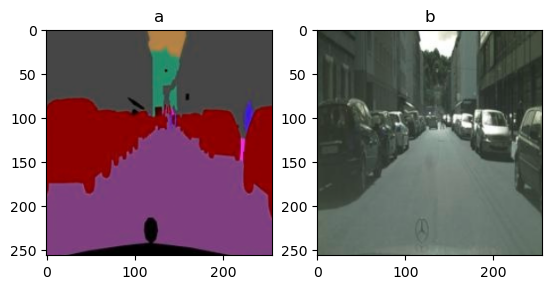

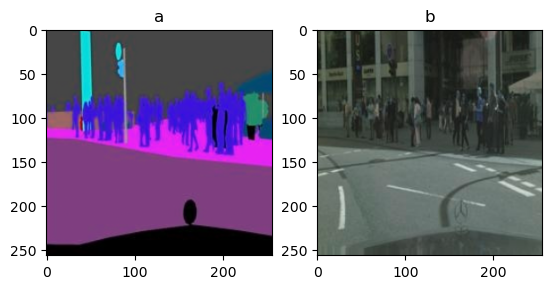

In [4]:
dataloader = DataLoader(Dataset_(path_a_train, path_b_train), batch_size=1, shuffle=True)
n = 0
for image_a, image_b in dataloader:
    if n == 2:
        break
    n += 1
    image_a = image_a.numpy().squeeze().transpose([1,2,0])
    image_b = image_b.numpy().squeeze().transpose([1,2,0])
    plt.subplot(1,2,1), plt.imshow(image_a/2+0.5), plt.title('a')
    plt.subplot(1,2,2), plt.imshow(image_b/2+0.5), plt.title('b')
    plt.show()

# Network Structure

## Discriminator

In [5]:
class Downsample(nn.Module):
    #
    def __init__(self, in_channels, out_channels, stride=2, apply_norm='in'):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False)
        ])
        if apply_norm == 'in':
            self.layers.append(nn.InstanceNorm2d(out_channels))
        if apply_norm == 'bn':
            self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.LeakyReLU(0.2))
    #
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [6]:
class Discriminator(nn.Module):
    #
    def __init__(self, channel=channel_d):
        super().__init__()
        self.layers = nn.ModuleList()
        channels = [6, 64, 128, 256, 512]
        strides = [2, 2, 2, 1]
        apply_norms = [False, 'in', 'in', 'in']
        for i in range(4):
            self.layers.append(Downsample(channels[i], channels[i+1], stride=strides[i], apply_norm=apply_norms[i]))
        self.layers.append(nn.Conv2d(channels[i+1], 1, 4, stride=1, padding=1))
    #
    def forward(self, x1, x2):
        x = T.cat([x1, x2], 1)
        for layer in self.layers:
            x = layer(x)
        return x 

## Generator

In [7]:
class Upsample(nn.Module):
    #
    def __init__(self, in_channels, out_channels, apply_dropout=False):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False), 
            # nn.BatchNorm2D(out_channels)
            nn.InstanceNorm2d(out_channels)
        ])
        if apply_dropout:
            self.layers.append(nn.Dropout(0.5))
        self.layers.append(nn.ReLU())
    #
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
class Generator(nn.Module):
    #
    def __init__(self, channel=channel_g):
        super().__init__()
        # down
        self.layers_down = nn.ModuleList([
            Downsample(3, channel, apply_norm=False)
        ])
        for i in range(7):
            in_channels = min(channel * 2**i, 512)
            out_channels = min(channel * 2**(i+1), 512)
            if i == 6:
                self.layers_down.append(Downsample(in_channels, out_channels, apply_norm=False))
            else:
                self.layers_down.append(Downsample(in_channels, out_channels))
        # up
        self.layers_up = nn.ModuleList([
            Upsample(channel*8, channel*8, apply_dropout=True)
        ])
        for i in range(6):
            in_channels = min(channel * 2**(7-i), 1024)
            out_channels = min(channel * 2**(5-i), 512)
            apply_dropout = True if i<=1 else False
            self.layers_up.append(Upsample(in_channels, out_channels, apply_dropout=apply_dropout))
        self.layers_up.append(nn.ConvTranspose2d(channel*2, 3, 4, stride=2, padding=1))
    #
    def forward(self, x):
        # down
        middle_outputs = []
        for i, layer in enumerate(self.layers_down):
            x = layer(x)
            if i < 7:
                middle_outputs.append(x)
        # up
        middle_outputs.reverse()
        for i, layer in enumerate(self.layers_up):
            if i >= 1:
                x = T.cat([x, middle_outputs[i-1]], axis=1)
            x = layer(x)
        return T.tanh(x)

# Show

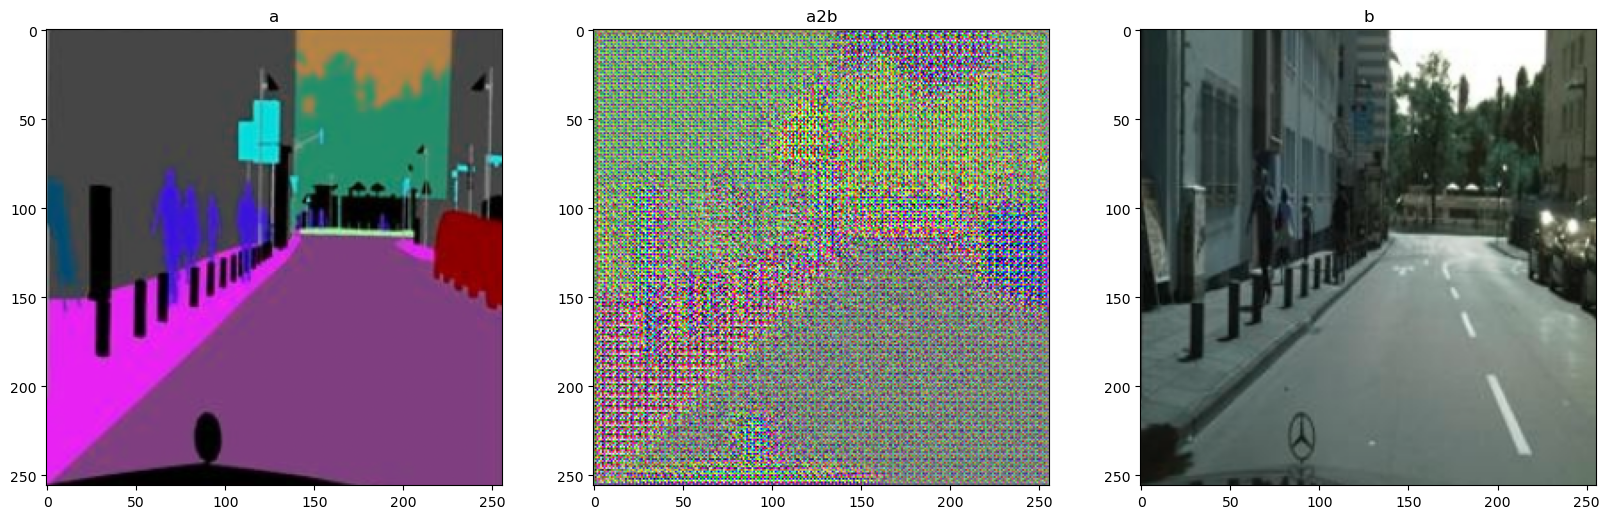

In [9]:
@T.no_grad()
def show(net=None):
    #
    if net is None:
        net = Generator().to(device)
    net.eval()
    #
    dataloader = DataLoader(Dataset_(path_a_test, path_b_test), batch_size=1, shuffle=True)
    for image_a, image_b in dataloader:
        break
    image_a = image_a.to(device)
    image_b = image_b.numpy().squeeze().transpose([1,2,0]) * 0.5 + 0.5
    image_a2b = net(image_a).cpu().numpy().squeeze().transpose([1,2,0]) * 0.5 + 0.5
    image_a = image_a.cpu().numpy().squeeze().transpose([1,2,0]) * 0.5 + 0.5
    #
    plt.figure(figsize=[20,20])
    plt.subplot(1,3,1), plt.imshow(image_a), plt.title('a')
    plt.subplot(1,3,2), plt.imshow(image_a2b), plt.title('a2b')
    plt.subplot(1,3,3), plt.imshow(image_b), plt.title('b')
    plt.show()
    net.train()


show()

# Train

In [10]:
def trainer_d(net_g, net_d, optimizer_d, image_a, image_b):
    #
    src_b = net_d(image_b, image_a)
    # loss_d_b = -T.mean(T.log(F.sigmoid(src_b)+1e-8))
    loss_d_b = F.binary_cross_entropy_with_logits(src_b, T.ones_like(src_b))
    #
    image_a2b = net_g(image_a)
    src_a2b = net_d(image_a2b.detach(), image_a)
    # loss_d_a2b = -T.mean(T.log(1-F.sigmoid(src_a2b)+1e-8))
    loss_d_a2b = F.binary_cross_entropy_with_logits(src_a2b, T.zeros_like(src_a2b))
    #
    loss_d = loss_d_b + loss_d_a2b
    optimizer_d.zero_grad()
    loss_d.backward()
    optimizer_d.step()

In [11]:
def trainer_g(net_g, net_d, optimizer_g, image_a, image_b):
    #
    image_a2b = net_g(image_a)
    loss_g_pix = T.mean(T.abs(image_a2b - image_b))
    #
    src_a2b = net_d(image_a2b, image_a)
    # loss_d_a2b = -T.mean(T.log(F.sigmoid(src_a2b)+1e-8))
    loss_d_a2b = F.binary_cross_entropy_with_logits(src_a2b, T.ones_like(src_a2b))
    #
    loss_g = λ_pix*loss_g_pix + loss_d_a2b 
    optimizer_g.zero_grad()
    loss_g.backward()
    optimizer_g.step()

In [12]:
def train(epochs, load_model=False):
    #
    net_g = Generator().to(device)
    net_d = Discriminator().to(device)
    net_d.train()
    optimizer_g = T.optim.Adam(net_g.parameters(), learning_rate_g, betas=(0.5,0.999))
    optimizer_d = T.optim.Adam(net_d.parameters(), learning_rate_d, betas=(0.5,0.999))
    if load_model:
        net_g.load_state_dict(T.load(path_work + 'net_g.pt'))
        optimizer_g.load_state_dict(T.load(path_work + 'optimizer_g.pt'))
        net_d.load_state_dict(T.load(path_work + 'net_d.pt'))
        optimizer_d.load_state_dict(T.load(path_work + 'optimizer_d.pt'))
        with open(path_work+'epoch.txt', 'r') as f:
            epoch_start = int(f.read())
    else:
            epoch_start = -1
    # scheduler_g = T.optim.lr_scheduler.StepLR(optimizer_g, step_size=200, gamma = 0.5, last_epoch=epoch_last)
    # scheduler_d = T.optim.lr_scheduler.StepLR(optimizer_d, step_size=200, gamma = 0.5, last_epoch=epoch_last)
    #
    iteration = 0
    for epoch in range(epoch_start + 1, epochs):
        time_start = time.time()
        dataloader = DataLoader(Dataset_(path_a_train, path_b_train), batch_size=batch_size, shuffle=True, num_workers=num_workers)
        for image_a, image_b in dataloader:
            net_g.train()
            iteration += 1             
            image_a, image_b = image_a.to(device), image_b.to(device)
            trainer_d(net_g, net_d, optimizer_d, image_a, image_b)
            if iteration % step_g == 0:
                trainer_g(net_g, net_d, optimizer_g, image_a, image_b)
            # scheduler_g.step()
            # scheduler_d.step()
    #
        if epoch % 1 == 0:
            print('Epoch: ', epoch, ', lteration: ', iteration)    
            show(net_g)        
            T.save(net_d.state_dict(), path_work + 'net_d.pt')
            T.save(optimizer_d.state_dict(), path_work + 'optimizer_d.pt')
            T.save(net_g.state_dict(), path_work + 'net_g.pt')
            T.save(optimizer_g.state_dict(), path_work + 'optimizer_g.pt')
            with open(path_work+'epoch.txt', 'w') as f:
                f.write(str(epoch))
        print('This epoch cost {} seconds'.format(time.time() - time_start))

In [13]:
# train(epochs=1, load_model=False)

In [14]:
# train(epochs=epochs, load_model=True)

# Test

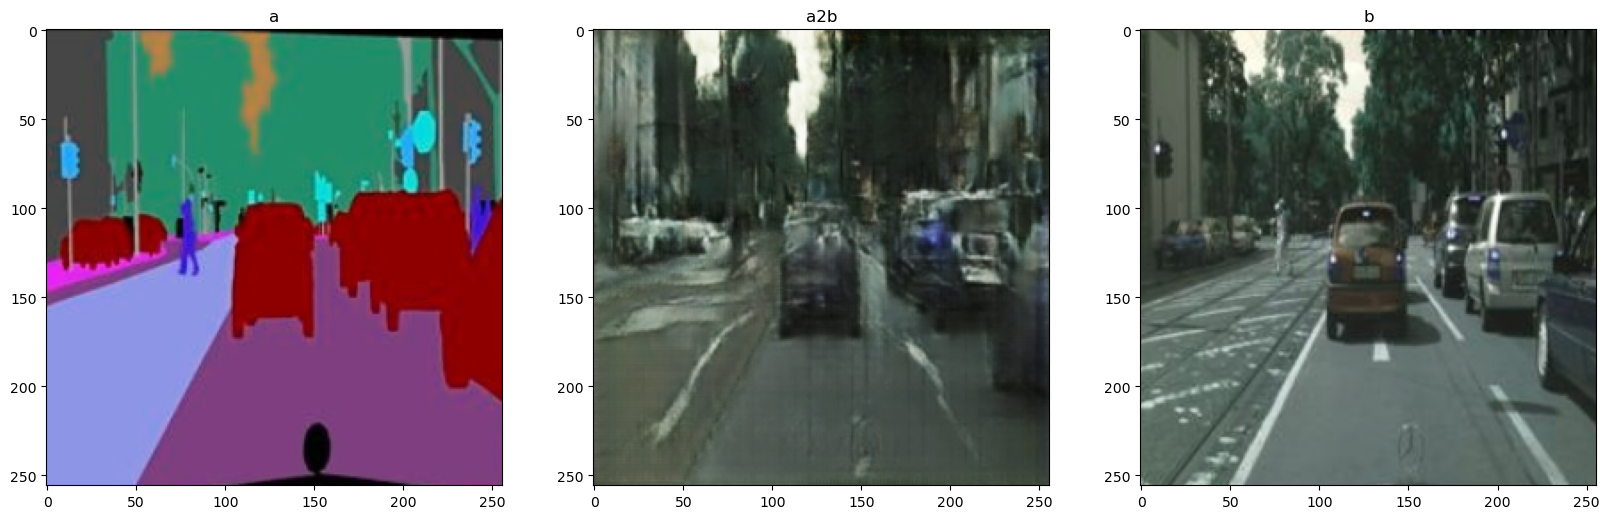

In [15]:
net = Generator().to(device)
net.load_state_dict(T.load(path_work + 'net_g.pt'))
show(net)